In [303]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import datetime
from pylab import rcParams
import statsmodels.api as sm

In [304]:
import warnings
warnings.filterwarnings('ignore')

In [305]:
# Define the ticker symbol for gold
gold_ticker = "GC=F"  

end_date = datetime.datetime.now().strftime('%Y-%m-%d')

start_date = (datetime.datetime.now() - datetime.timedelta(days=8*365)).strftime('%Y-%m-%d')

data = yf.download(gold_ticker, start=start_date, end=end_date)

data = data.reset_index()

[*********************100%%**********************]  1 of 1 completed


In [306]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-05-02,1292.099976,1304.400024,1290.400024,1294.699951,1294.699951,192
1,2016-05-03,1292.699951,1301.500000,1284.500000,1290.699951,1290.699951,151
2,2016-05-04,1286.900024,1290.000000,1273.000000,1273.300049,1273.300049,109
3,2016-05-05,1282.900024,1286.000000,1270.800049,1271.400024,1271.400024,330
4,2016-05-06,1278.599976,1295.599976,1276.900024,1292.900024,1292.900024,305


In [307]:
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2005,2024-04-23,2327.699951,2330.800049,2294.199951,2327.699951,2327.699951,171
2006,2024-04-24,2321.300049,2328.699951,2314.600098,2324.500000,2324.500000,95
2007,2024-04-25,2315.000000,2329.800049,2305.000000,2329.800049,2329.800049,1024
2008,2024-04-26,2347.899902,2347.899902,2332.800049,2334.800049,2334.800049,717
2009,2024-04-29,2334.800049,2345.500000,2327.899902,2345.399902,2345.399902,717


# Exploratory Data Analysis

In [308]:
# taking required column 

data = data[['Date', 'Close']]

In [309]:
# making date as datetime type

data['Date'] = pd.to_datetime(data['Date'])

In [310]:
# renaming Close as Price

data.rename(columns = {'Close': 'Price'}, inplace = True)

In [311]:
data['Price'] = np.round(data['Price'], 2)

In [312]:
# grouping data by week, month and year

data_byweek = data.groupby(pd.Grouper(key = 'Date', freq = 'W')).mean()
data_bymonth = data.groupby(pd.Grouper(key = 'Date', freq = 'M')).mean()
data_byyear = data.groupby(pd.Grouper(key = 'Date', freq = 'Y')).mean()

In [313]:
# rounding price by two decimal

for i in [data_bymonth, data_byweek, data_byyear]:
    i['Price'] = np.round(i['Price'], 2)

In [314]:
# let us set Date as index and consider all date in the data (even holiday)

data1 = data.set_index('Date')
start_date = data1.index.min()
end_date = data1.index.max()
date_range = pd.date_range(start=start_date, end=end_date)
data1 = data1.reindex(date_range)

In [315]:
data1.shape

(2920, 1)

In [316]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2920 entries, 2016-05-02 to 2024-04-29
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   2010 non-null   float64
dtypes: float64(1)
memory usage: 45.6 KB


In [317]:
data1.isnull().sum()

Price    910
dtype: int64

## Observation

From above EDA we can see that we have 910 null values. 

In [318]:
data1.fillna(data1.Price.mean(), inplace = True)

<AxesSubplot:xlabel='Date', ylabel='Price'>

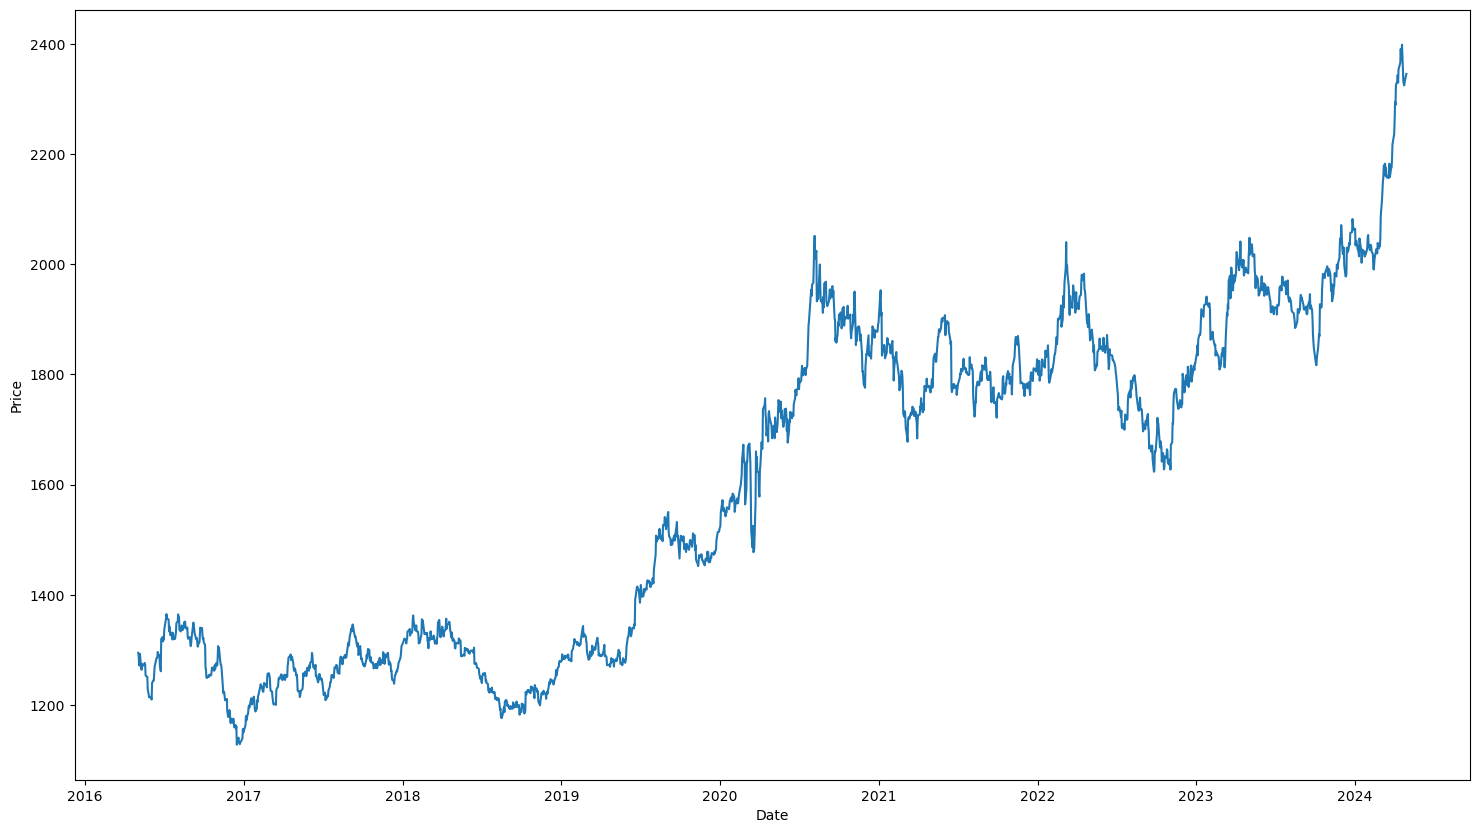

In [319]:
# plot by day
plt.figure(figsize = (18, 10))
sns.lineplot(data = data, x = 'Date', y = 'Price')

<AxesSubplot:xlabel='Date', ylabel='Price'>

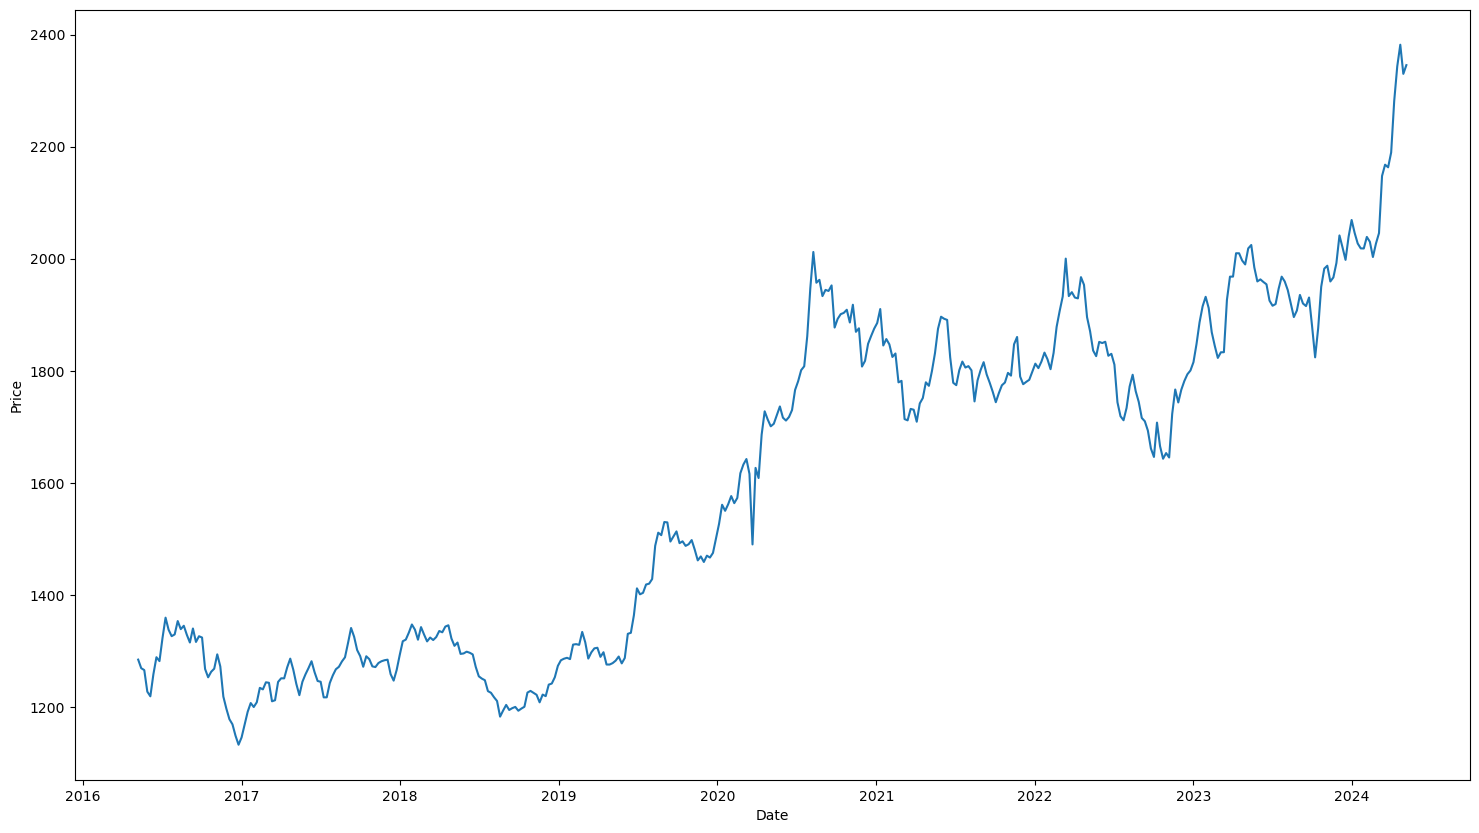

In [320]:
# plot by week

plt.figure(figsize = (18, 10))
sns.lineplot(data = data_byweek, x = 'Date', y = 'Price')

<AxesSubplot:xlabel='Date', ylabel='Price'>

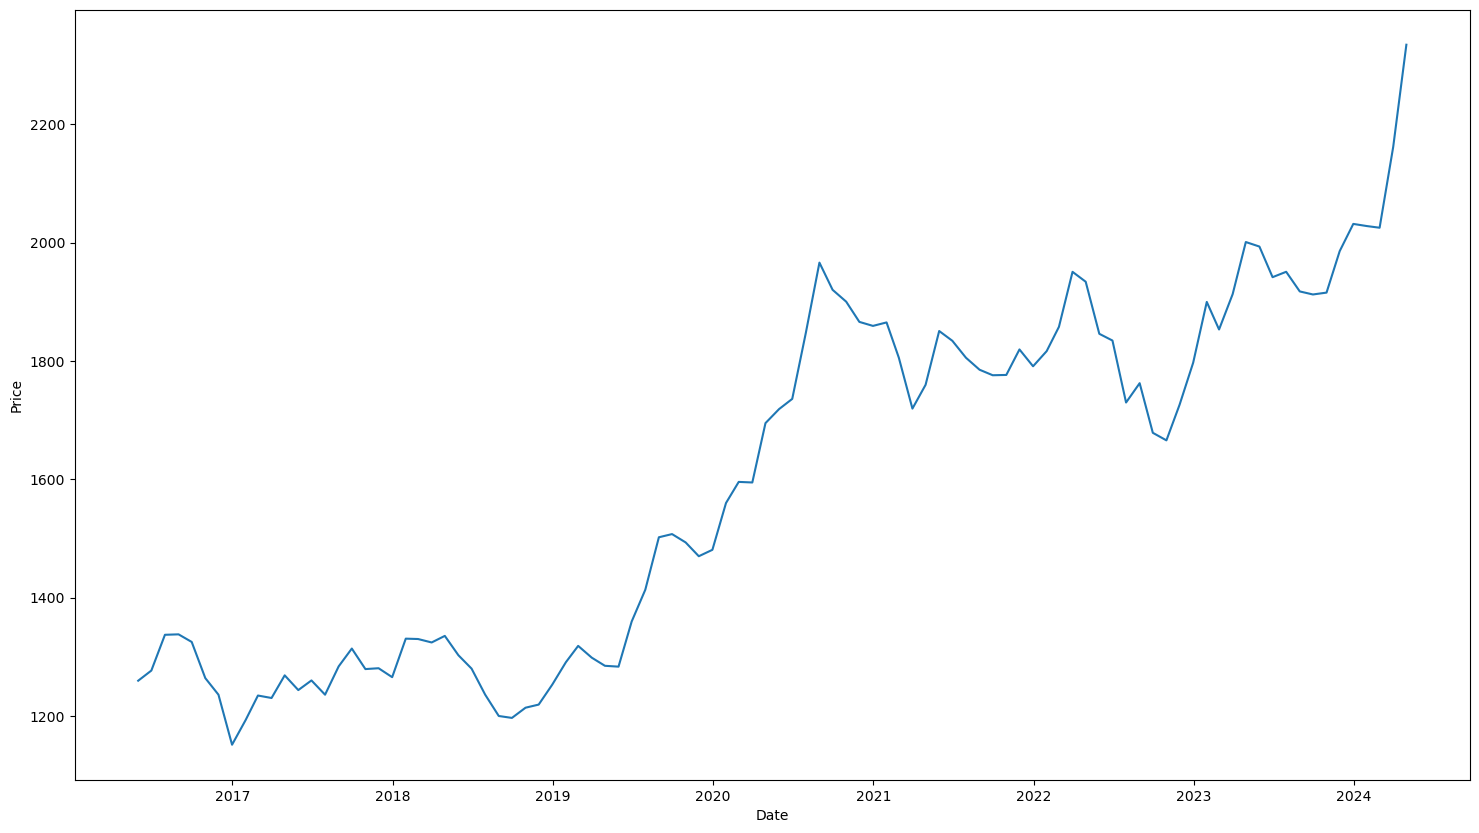

In [321]:
# plot by month

plt.figure(figsize = (18, 10))
sns.lineplot(data = data_bymonth, x = 'Date', y = 'Price')

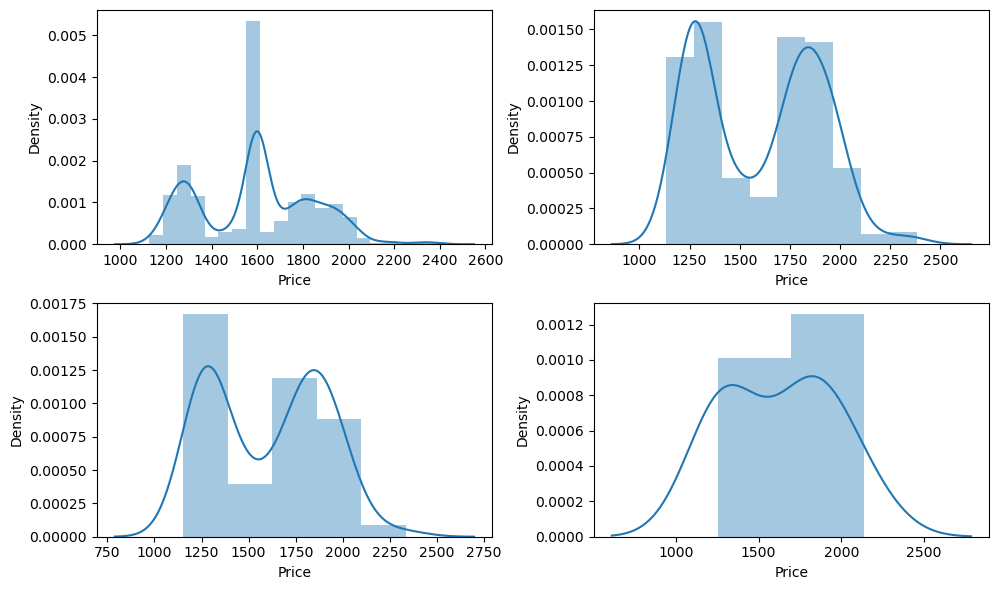

In [322]:
# Let us see distribution of price

plt.figure(figsize = (10, 6))
for num, i in enumerate([data1, data_byweek, data_bymonth, data_byyear], 1):
    plt.subplot(2, 2, num)
    sns.distplot(i['Price'])
    
plt.tight_layout()

In [323]:
# Let us see the value of Skewness and Kurtosis for daily price column

from scipy.stats import skew, kurtosis

skew_value = round(skew(data1['Price']), 4)
kurt_value = round(kurtosis(data1['Price']), 4)
print('The value of skewness for price data is,', skew_value)
print('The value of kurtosis for price data is,', kurt_value)

The value of skewness for price data is, 0.1272
The value of kurtosis for price data is, -0.5718


## Observation:

Value of Skewness is near to zero. This means the dataset is symmeteric. Also, kurtosis is -0.5 which tells us that tails are lighter.
This suggest that there is less chance of getting extreme values.

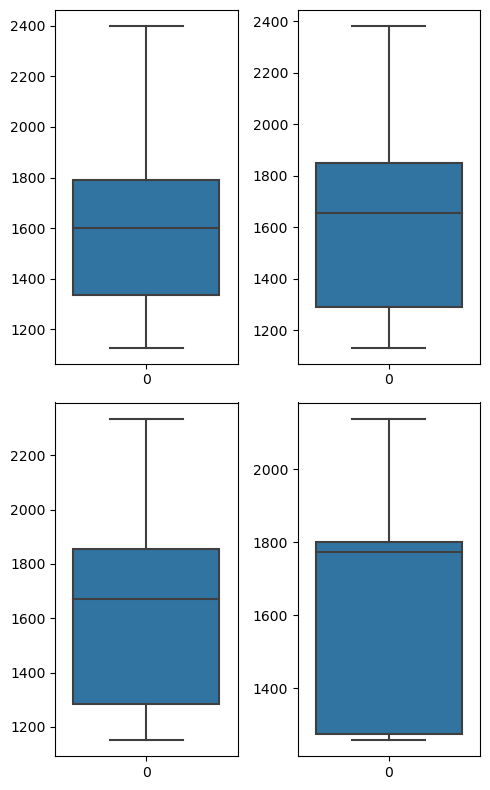

In [324]:
# let us see boxplot of price 

plt.figure(figsize = (5, 8))
for num, i in enumerate([data1, data_byweek, data_bymonth, data_byyear], 1):
    plt.subplot(2, 2, num)
    sns.boxplot(i['Price'])
    
   
plt.tight_layout()

In [325]:
# Let us check outliers using IQR method

for col in data1.columns:
    q1 = data1[col].quantile(0.25)
    q3 = data1[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5*iqr
    upper_bound = q3 + 1.5*iqr
    outliers = data1[(data1[col] < lower_bound) | (data1[col] > upper_bound)]
    
print('Total number of outliers in the given dataset is,', len(outliers))

Total number of outliers in the given dataset is, 0


## Observation;

From above boxplot as well as IQR method, we can say that there is no outlier in the price column.

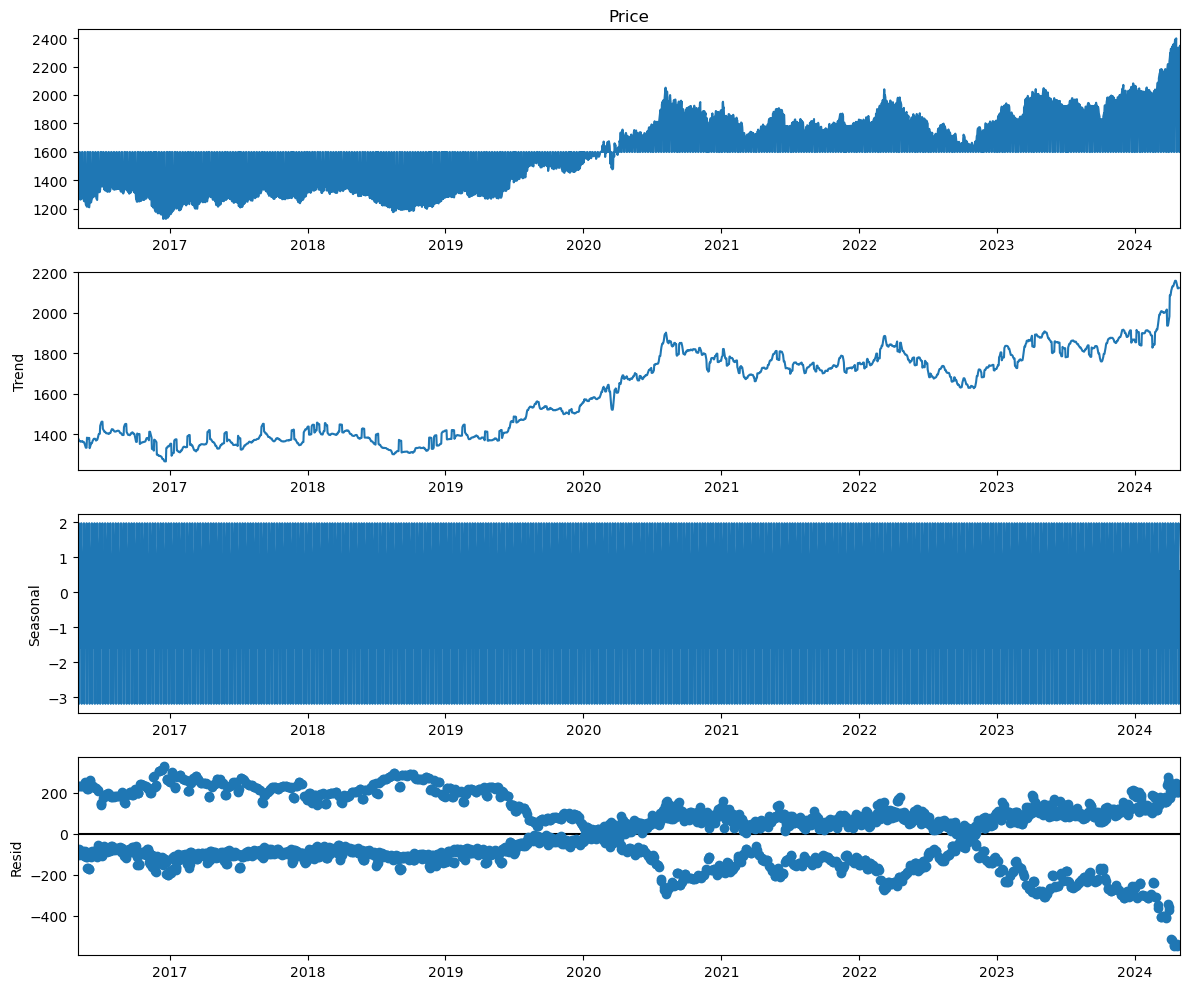

In [326]:
# Now let us look at the series decomposition

rcParams['figure.figsize'] = 12, 10
decomposition = sm.tsa.seasonal_decompose(data1.Price, model='additive') # additive seasonal index
fig = decomposition.plot()
plt.show()

## Observation:

In above decomposition, we can see the trend is upward, but the error i.e. residual is too high and seasonality is unclear.
    

In [327]:
# Let us resample the data by weekly basis

data1_byweekly = data1.resample('W').mean()

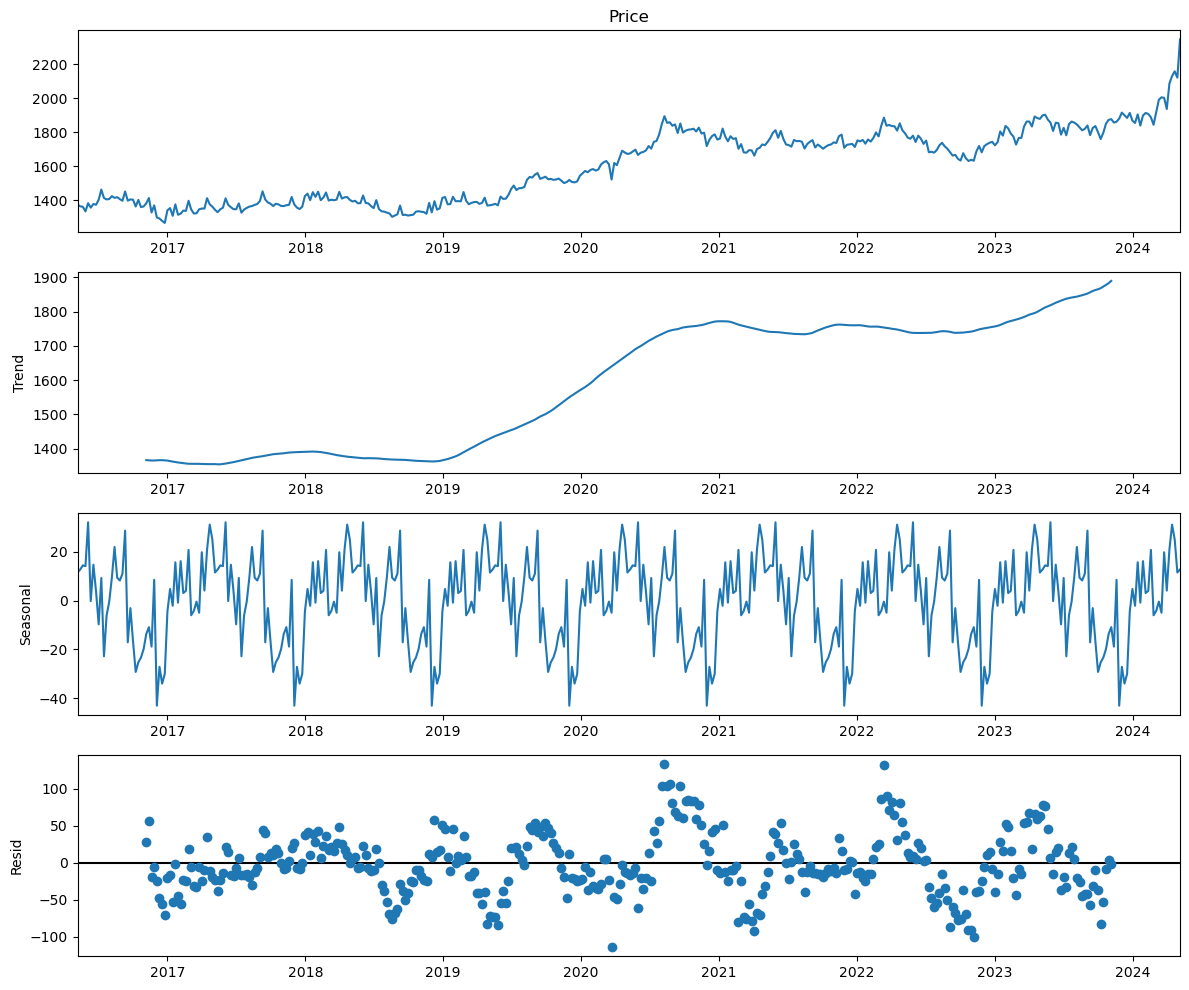

In [328]:
# let us again see the decomposition plot

rcParams['figure.figsize'] = 12, 10
decomposition = sm.tsa.seasonal_decompose(data1_byweekly.Price, model='additive') # additive seasonal index
fig = decomposition.plot()
plt.show()

## Observation:

Now, we can see some clearity in seasonality and less residual points.

In [329]:
# Let us again resample by monthly basis and see the decomposition.

data1_bymonthly = data1.resample('M').mean()

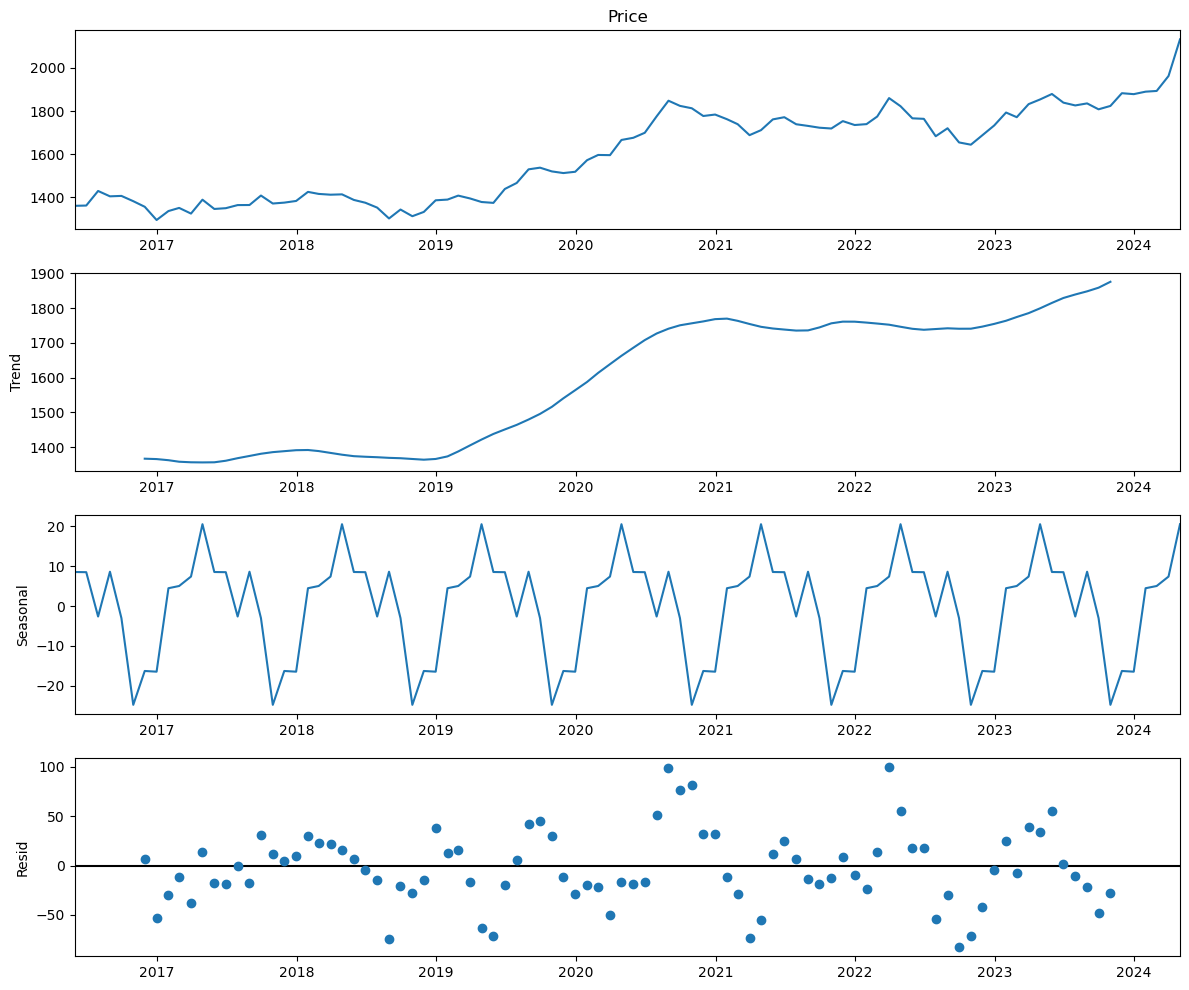

In [330]:
# Let us see the desomposition plot

rcParams['figure.figsize'] = 12, 10
decomposition = sm.tsa.seasonal_decompose(data1_bymonthly.Price, model='additive') # additive seasonal index
fig = decomposition.plot()
plt.show()

## Observation:

In above decomposition, we can see clear trend, seasonality and less residual points.

## Test of stationary

In [331]:
# Now, let us check whether the dataset is stationary or not using ADF(Augumented Dicky-Fuller Test).

from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(data1_bymonthly['Price'])

if (adf_test[1] > 0.05):
    print('The given time series data is not stationary')
else:
    print('The given time series data is stationary')        

The given time series data is not stationary


## Observation:

As given time data series is not stationary, let us make it stationary by making mean and variance constant.

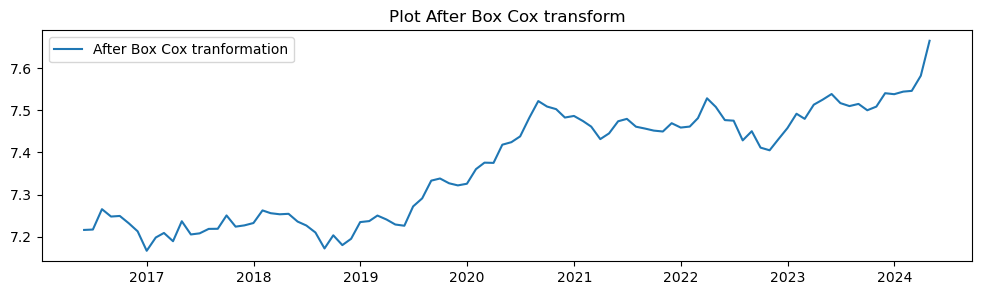

In [332]:
# let us make variance constant using box cox transformation

from scipy.stats import boxcox
data_boxcox = pd.Series(boxcox(data1_bymonthly['Price'], lmbda=0), index = data1_bymonthly.index)

plt.figure(figsize=(12,3))
plt.plot(data_boxcox, label='After Box Cox tranformation')
plt.legend(loc='best')
plt.title('Plot After Box Cox transform')
plt.show()

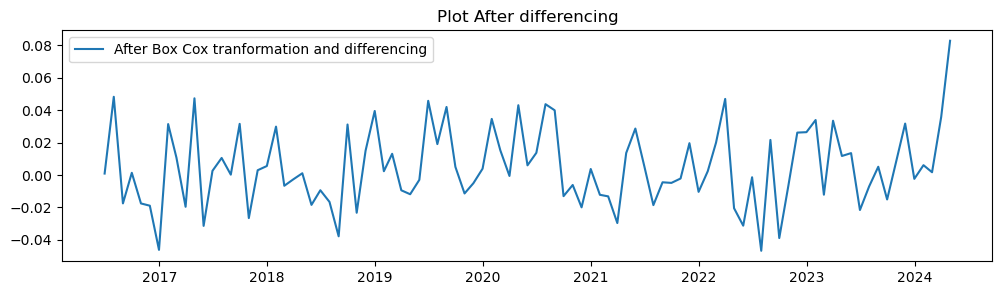

In [333]:
# Now, to stabalize both mean and variance, let us perform differencing i.e. remove trend

data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), data1_bymonthly.index)
plt.figure(figsize=(12,3))
plt.plot(data_boxcox_diff, label='After Box Cox tranformation and differencing')
plt.legend(loc='best')
plt.title('Plot After differencing')
plt.show()

In [334]:
# Let us look at data_boxcox_diff series

data_boxcox_diff.head()

2016-05-31         NaN
2016-06-30    0.000929
2016-07-31    0.048296
2016-08-31   -0.017483
2016-09-30    0.001393
Freq: M, dtype: float64

In [335]:
# Let us remove the NA value we have in the series

data_boxcox_diff.dropna(inplace=True)

In [336]:
# Now, let us again perform ADF to check whether the time series data is stationary or not

from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(data_boxcox_diff)

if (adf_test[1] > 0.05):
    print('The given time series data is not stationary')
else:
    print('The given time series data is stationary')

The given time series data is stationary


## ACF and PACF Plot

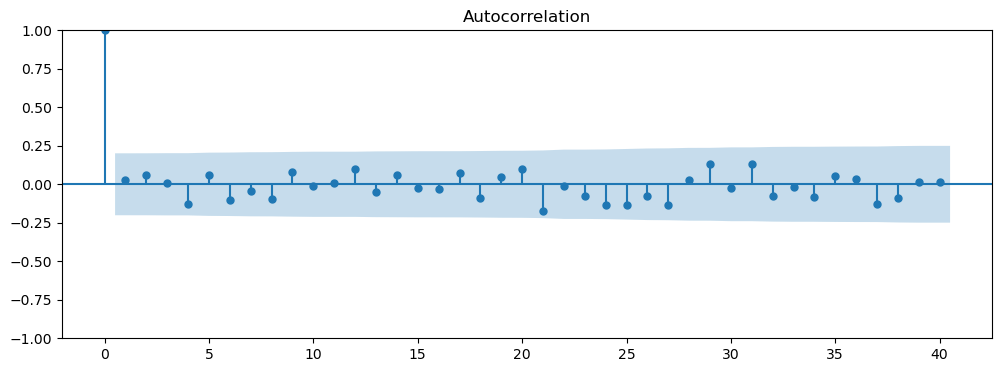

In [337]:
# Let us plot ACF 

from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(12,4))
plot_acf(data_boxcox_diff, ax=plt.gca(), lags = 40)
plt.show()

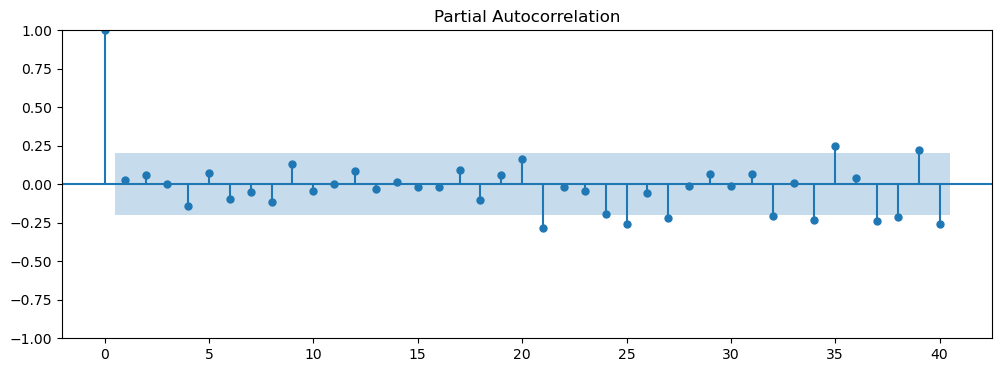

In [338]:
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(12,4))
plot_pacf(data_boxcox_diff, ax=plt.gca(), lags = 40)
plt.show()

## Observation

As there is no spike outside the error band in ACF plot. This suggest that there is no need of MA component in ARIMA plot. Hence, q = 0.
Also, we can see spike outside the error range at lag 21 in PACF plot. So, we can say that AR component of ARIMA model has a value of p = 21. 

## Model Building

In [339]:
# Let us split traning and testing data

train_len = 84  # 84 months training data (total number of months in a dataset are 96)
train = data1_bymonthly[0:train_len] 
test = data1_bymonthly[train_len:]
train_data_boxcox = data_boxcox[:train_len]
test_data_boxcox = data_boxcox[train_len:]
train_data_boxcox_diff = data_boxcox_diff[:train_len-1]
test_data_boxcox_diff = data_boxcox_diff[train_len-1:]

### AR Model Building 

In [349]:
import statsmodels.api as sm
model = sm.tsa.arima.ARIMA(train_data_boxcox_diff, order=(10, 0, 0)) 
model_fit = model.fit()

In [350]:
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['ar_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox_diff'].cumsum()
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox'].add(data_boxcox[0])
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])

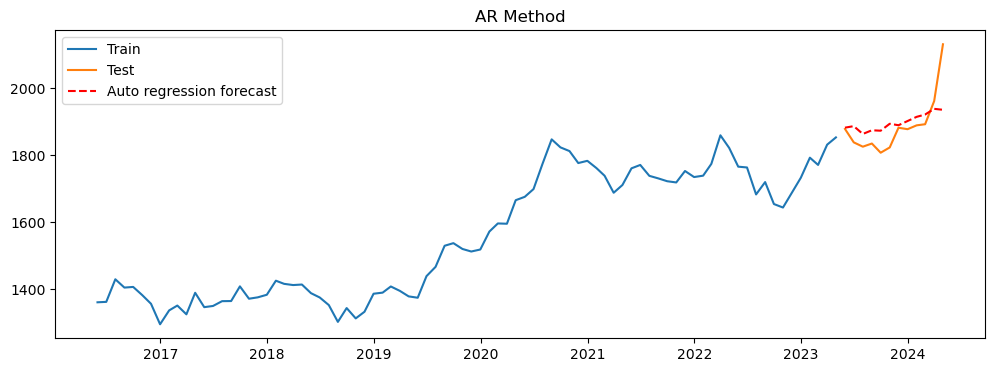

In [351]:
plt.figure(figsize=(12,4))
plt.plot(train['Price'], label='Train')
plt.plot(test['Price'], label='Test')
plt.plot(y_hat_ar['ar_forecast'][test.index.min():], "--", label='Auto regression forecast', color = 'red')
plt.legend(loc='best')
plt.title('AR Method')
plt.show()

In [352]:
# Let us calculate root mean square error and mean absolute percentage error

from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(test['Price'], y_hat_ar['ar_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Price']-y_hat_ar['ar_forecast'][test.index.min():])/test['Price'])*100,2)
print('Root mean square error for AR Model is', rmse)
print('Mean absolute percentage error for AR Model is, ', mape, '%')

Root mean square error for AR Model is 68.07
Mean absolute percentage error for AR Model is,  2.46 %
